# `WordCloud by QA` notebook
### Descriprion
Notebook includes pipeline of extraction of vital personal information from reviews. Then all that range of strings that describe person are used to build WordCloud visualization. However, none of attempts were successful. 

In [134]:
%pwd

'/home/jupyter/work/resources/nlp-coursework'

In [135]:
from src.nlp.application import (Pipeline, 
                                 get_df_by_film_and_person, 
                                 get_df_by_person, 
                                 collect_sents_to_summarize,
                                 split_opinions_to_chunks)
from datasets_ import DatasetLoader

import dill
from tqdm.notebook import tqdm
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook
from wordcloud import WordCloud


from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
from transformers import MBartTokenizer, MBartForConditionalGeneration
from transformers import AutoTokenizer, T5ForConditionalGeneration
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers.pipelines.question_answering import QuestionAnsweringPipeline

import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

import warnings
warnings.filterwarnings("ignore")

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [136]:
data = DatasetLoader.load_named_entities_dataset(show_path=True)
data

/home/jupyter/work/resources/nlp-coursework/data/named_entities.csv


,ne,occurrences,film_id,n_sents
0,Кинг,"[Я плакала над глубокой и грустной историей, к...",435,150
1,Дарабонт,[После взросления и прочтения книги фильм Дара...,435,65
2,Перси,[Особенно нелепа вся эта линия с травлей Перси...,435,94
3,Депрессия,"[За то, что работает по блату (во времена Депр...",435,1
4,Делакруа,"[И кстати, ради большей слезовыжималки сценари...",435,26
...,...,...,...,...
108191,Сергей Эйзенштейн,[В качестве наглядного примера могу предложить...,969760,1
108192,Ферруччо,[Молодой Ферруччо - типичный англо-саксонский ...,969760,9
108193,Эдуардо де Филиппо,[Авторам смотреть старые итальянские фильмы и ...,969760,1
108194,Ютюба,[И он по законам мотивашек с Ютюба читает как ...,969760,1


In [137]:
del_datasphere_variables('model')

KeyError: 'model'

In [138]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model_name = "AlexKay/xlm-roberta-large-qa-multilingual-finedtuned-ru"
model = pipeline('question-answering', model=model_name, tokenizer=model_name, device=0)

cuda:0


Downloading:   0%|          | 0.00/781 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.08G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/516 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [133]:
#!g1.1
!export TOKENIZERS_PARALLELISM=false

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [149]:
#!g1.1
def get_person_characteristics(data: pd.DataFrame, 
                               name: str, 
                               model: QuestionAnsweringPipeline,
                               film_id: int = None,
                               ):
    from src.nlp.preprocessing import clean
    from random import shuffle
    import numpy as np
    import copy
    
    _N_SENTS = 100
    
    print('Collecting sentences to retrieve characteristics...')
    
    if film_id is not None:
        listed_opinions = collect_sents_to_summarize(
            get_df_by_film_and_person(data, film_id, name), 
            n_sents = _N_SENTS
        )
    else:
        listed_opinions = collect_sents_to_summarize(
            get_df_by_person(data, name), 
            n_sents = _N_SENTS
        )       
    
    opinions = '\n'.join(listed_opinions)
#     print(opinions, end='\n------------------------------------\n')
    opinions = clean(opinions, char_clean_only=True, lowercase=False)
#     print(opinions)
    
    print('Built opinions text!')
    
    answers = []
    scores = []
    questions = [
                    {
                        'question': f'Какая {name}?',
                        'context': opinions
                    },
                    {
                        'question': f'Что сделал {name}?',
                        'context': opinions
                    },
                    {
                        'question': f'Что хорошо у {name}?',
                        'context': opinions
                    },
                    {
                        'question': f'Что плохо у {name}?',
                        'context': opinions
                    }                
                ]
    
    print('Questions initialized!')
    
    os.environ["TOKENIZERS_PARALLELISM"] = "true"

    questions_to_remove = []
    
    try:
        while questions:
            questions = [{'question': dct['question'], 'context': opinions} for dct in questions]
            
            for i, question in enumerate(questions):
                print('Thinking on question number', i, '...')
                answer = model(question)
                print(question['question'])
                print(answer['answer'])
                opinions = opinions.replace(answer['answer'], ' ')
                if answer['answer'] == '':
                    print('question:', question)
                    print(answer['answer'])
                    questions_to_remove.append(i)
                answers.append(answer['answer'])
                scores.append(answer['score'])
                
            if questions_to_remove:
                print('OLD SET OF QUESTIONS:', questions)
                new_questions = []
                for i, question in enumerate(questions):
                    if i not in questions_to_remove:
                        new_questions.append(question)
                
                questions = new_questions
                questions_to_remove = []
                print('NEW SET OF QUESTIONS:', questions)

    except KeyboardInterrupt:
        pass        
    finally:
        return np.array(scores), np.array(answers)
        
        

In [142]:
#!g1.1
import warnings

warnings.filterwarnings('ignore')

In [150]:
#!g1.1
scores, answers = get_person_characteristics(data, 'Хэтэуэй', model)

Traceback (most recent call last):
  File "/kernel/lib/python3.8/site-packages/IPython/core/completer.py", line 2037, in _complete
    for m in matcher(text)])
  File "/kernel/lib/python3.8/site-packages/IPython/core/completer.py", line 1265, in magic_matches
    global_matches = self.global_matches(bare_text)
  File "/kernel/lib/python3.8/site-packages/IPython/core/completer.py", line 674, in global_matches
    shortened = {"_".join([sub[0] for sub in word.split('_')]) : word
  File "/kernel/lib/python3.8/site-packages/IPython/core/completer.py", line 675, in <dictcomp>
    for word in lst if snake_case_re.match(word)}
TypeError: expected string or bytes-like object
Traceback (most recent call last):
  File "/kernel/lib/python3.8/site-packages/IPython/core/completer.py", line 2037, in _complete
    for m in matcher(text)])
  File "/kernel/lib/python3.8/site-packages/IPython/core/completer.py", line 1265, in magic_matches
    global_matches = self.global_matches(bare_text)
  File "/ker

Built opinions text!
Questions initialized!
Thinking on question number 0 ...
Какая Хэтэуэй?
 свежа, очаровательна и убедительна
Thinking on question number 1 ...
Что сделал Хэтэуэй?
 прекрасно справилась с этой ролью.
Thinking on question number 2 ...
Что хорошо у Хэтэуэй?
 свежа, очаровательна и убедительна
Thinking on question number 3 ...
Что плохо у Хэтэуэй?
 выглядит немного неестественно.
Thinking on question number 0 ...
Какая Хэтэуэй?
 невероятно красивая женщина.
Thinking on question number 1 ...
Что сделал Хэтэуэй?
 вполне достойно справилась со своей ролью.
Thinking on question number 2 ...
Что хорошо у Хэтэуэй?
 огромный потенциал
Thinking on question number 3 ...
Что плохо у Хэтэуэй?
 немного не хватает сексуальности,
Thinking on question number 0 ...
Какая Хэтэуэй?
 своенравная, дерзкая, гордая и опасная,
Thinking on question number 1 ...
Что сделал Хэтэуэй?
 стала Селиной Кайл.
Thinking on question number 2 ...
Что хорошо у Хэтэуэй?
 Неплохую игру
Thinking on question n

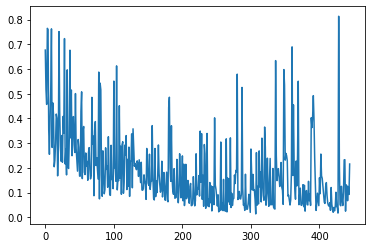

In [151]:
#!g1.1
plt.plot(scores)

In [153]:
#!g1.1
answers[:10]

array([' свежа, очаровательна и убедительна',
       ' прекрасно справилась с этой ролью.',
       ' свежа, очаровательна и убедительна',
       ' выглядит немного неестественно.',
       ' невероятно красивая женщина.',
       ' вполне достойно справилась со своей ролью.',
       ' огромный потенциал', ' немного не хватает сексуальности,',
       ' своенравная, дерзкая, гордая и опасная,', ' стала Селиной Кайл.'],
      dtype='<U72')

In [157]:
#!g1.1
clean_answers = np.array(list(map(lambda s: s.strip(' .,:'), answers)))
clean_answers[:10]

array(['свежа, очаровательна и убедительна',
       'прекрасно справилась с этой ролью',
       'свежа, очаровательна и убедительна',
       'выглядит немного неестественно', 'невероятно красивая женщина',
       'вполне достойно справилась со своей ролью', 'огромный потенциал',
       'немного не хватает сексуальности',
       'своенравная, дерзкая, гордая и опасная', 'стала Селиной Кайл'],
      dtype='<U71')

In [159]:
#!g1.1
chosen_clean_answers = clean_answers[scores > 0.18]
chosen_clean_answers[:20]

array(['свежа, очаровательна и убедительна',
       'прекрасно справилась с этой ролью',
       'свежа, очаровательна и убедительна',
       'выглядит немного неестественно', 'невероятно красивая женщина',
       'вполне достойно справилась со своей ролью', 'огромный потенциал',
       'немного не хватает сексуальности',
       'своенравная, дерзкая, гордая и опасная', 'стала Селиной Кайл',
       'Неплохую игру', 'немного переигрывает местами',
       'была очень убедительна', 'мастерски воплотила Энди на экране',
       'войти в образ Энди Сакс', 'не всё так однозначно',
       'талантливой актрисой', 'сыграла она просто блестяще',
       'безграничной надменности, сухости', 'обычной обаятельной девушки'],
      dtype='<U71')

In [164]:
#!g1.1
print(len(clean_answers) == len(scores))
len(clean_answers)

True


445

In [165]:
#!g1.1
import dill

with open('data/wordcloud/scores.np', 'wb') as f:
    dill.dump(scores, f)
with open('data/wordcloud/clean_answers.np', 'wb') as f:
    dill.dump(clean_answers, f)

In [ ]:
#!g1.1


In [ ]:
#!g1.1


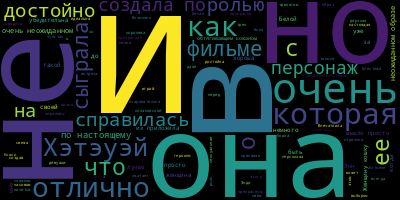

In [160]:
#!g1.1
wc = WordCloud().generate(' '.join(chosen_clean_answers))
wc.to_image()

In [167]:
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 2.3 MB/s eta 0:00:00a 0:00:01


ngram_range=(4, 4)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(26, 16)
Preparing values...

ngram_range=(5, 5)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(26, 9)
Preparing values...

ngram_range=(6, 6)
Building vocabulary...
Vectorizing documents...
docs_embs.shape=(26, 4)
Preparing values...



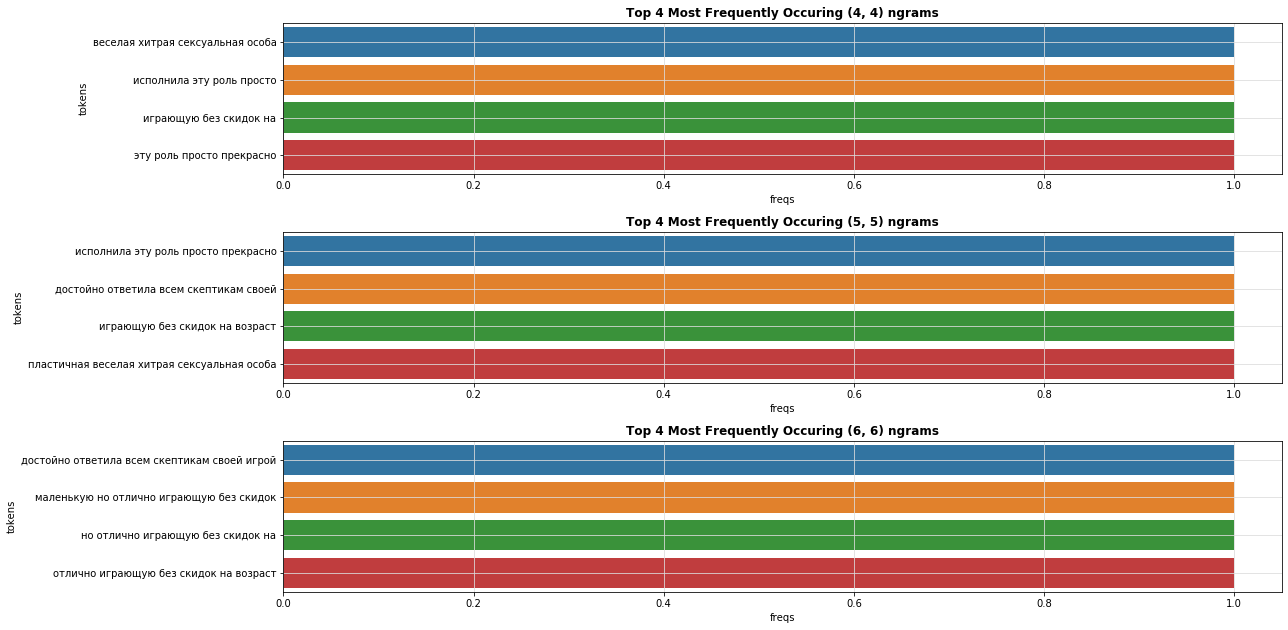

In [176]:
from src.nlp.visual import visualize_ngram_occurrences

visualize_ngram_occurrences(clean_answers[scores > 0.5], (4, 6), 4)

In [183]:
for i in range(3, len(clean_answers), 4):
    if scores[i] > 0.05:
        print(clean_answers[i])

выглядит немного неестественно
немного не хватает сексуальности
немного переигрывает местами
не всё так однозначно
безграничной надменности, сухости
не утратила человеческих чувств и чувство сострадания
мне непривычно видеть ее в такой роли
роль на самом деле небольшая
очень странно
чувствуется
была уж слишком напыщенна и изнеженна
повезло
образ у   Энн Хэтэуэй   здесь был действительно жутковатый
грима лица
Чего-то не хватает
мотивация не до конца показана
печаль, какая то тревога и чувство вины
слегка мальчишеском, гаврошевом образе
очень хороша
роль довольно ограничена
глубоким непостижимым взглядом и монологом о любви
я не могу относиться к ней объективно
сам ее образ раскрыт не полностью
ничуть не выпадала из 'веселой компании'
Каждое мгновение сыграно на 100%
пусть и не драматическая
держится на уровне
несогласие поклонников трилогии
больше экспрессии
Клишированная глупость
образ Белой Королевы изначально проигрышный
Честейн губаста и упряма
не идеальна, но достойна
она их прилож